In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

In [2]:
wine_quality = fetch_ucirepo(id=186)

# Pre-processing
df = wine_quality.data.original

def categorize_quality(quality):
    if quality < 7:
        return 'bad'
    else:
        return 'good'


df['quality_category'] = df['quality'].apply(categorize_quality)

red_wine_df = df[df['color'] == 'red']
white_wine_df = df[df['color'] == 'white']

df_array = [red_wine_df, white_wine_df, df]

In [ ]:
df_names = ['Red Wine', 'White Wine', 'Combined Wine']


def confusion_matrix_plot(y_test, y_pred, clf, model):
    # Create both normalized and raw confusion matrices
    cm_raw = confusion_matrix(y_test, y_pred)
    cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')  # Normalize by true class
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Raw counts confusion matrix
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_raw, display_labels=clf.classes_)
    disp1.plot(cmap=plt.cm.Blues, ax=ax1, values_format='d')
    ax1.set_title(f'Confusion Matrix (Raw Counts)\n{model.__class__.__name__}')
    
    # Normalized confusion matrix (shows percentages for each true class)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=clf.classes_)
    disp2.plot(cmap=plt.cm.Blues, ax=ax2, values_format='.2f')
    ax2.set_title(f'Confusion Matrix (Normalized)\n{model.__class__.__name__}')
    
    plt.tight_layout()
    plt.show()


def optimized_folds(model, X, y):
    best_score = 0
    best_folds = 0

    for folds in np.arange(2, 11):
        scores = cross_val_score(model, X, y, cv=folds, scoring='f1_macro')
        if scores.mean() > best_score:
            best_score = scores.mean()
            best_folds = folds

    print(f"Best Folds: {best_folds} | Best Score: {best_score}")
    return best_folds


def pr_curve(y_test, y_scores, model):
    
    precision, recall, _ = precision_recall_curve(y_test, y_scores, pos_label='good')
    
    ap_score = average_precision_score(y_test, y_scores, pos_label='good') # avg precision score
    
    baseline = len(y_test[y_test == 'good']) / len(y_test) # random guess baseline
    
    plt.figure(figsize=(10, 7))
    plt.plot(recall, precision, linewidth=2, label=f'PR Curve (AP = {ap_score:.3f})')
    plt.axhline(y=baseline, color='red', linestyle='--', linewidth=1, label=f'Random Baseline (AP = {baseline:.3f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # text box with key metrics
    textstr = f'Average Precision: {ap_score:.3f}\nBaseline: {baseline:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    
    return ap_score


def get_probability_scores(model, X_test):
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(X_test) # For models that support probability prediction
        good_index = list(model.classes_).index('good')
        return probabilities[:, good_index]
    elif hasattr(model, 'decision_function'): # For models with decision function 
        return model.decision_function(X_test)
    else:
        predictions = model.predict(X_test) # Fallback: use predicted class as binary score (not ideal for PR curve)
        return (predictions == 'good').astype(int)
    
def roc_curve_plot(y_test, y_scores, model):
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label='good')

    auc_score = roc_auc_score(y_test, y_scores)

    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve for {model.__class__.__name__}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.show()

Processing Red Wine...
Best Folds: 8 | Best Score: 0.5869938433437837
Best Folds: 8 | Best Score: 0.5869938433437837
              precision    recall  f1-score   support

         bad       0.87      0.97      0.92       413
        good       0.45      0.13      0.21        67

    accuracy                           0.86       480
   macro avg       0.66      0.55      0.56       480
weighted avg       0.81      0.86      0.82       480

              precision    recall  f1-score   support

         bad       0.87      0.97      0.92       413
        good       0.45      0.13      0.21        67

    accuracy                           0.86       480
   macro avg       0.66      0.55      0.56       480
weighted avg       0.81      0.86      0.82       480



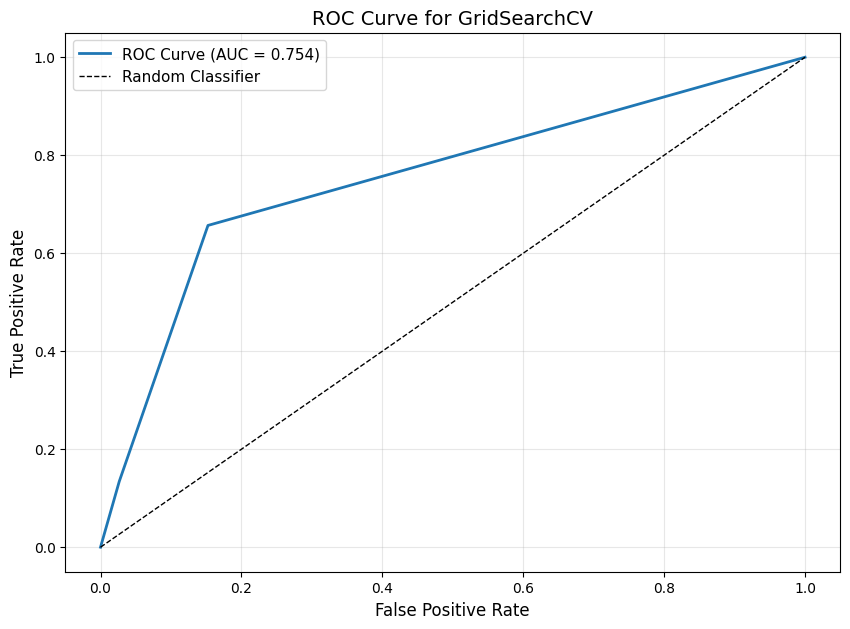

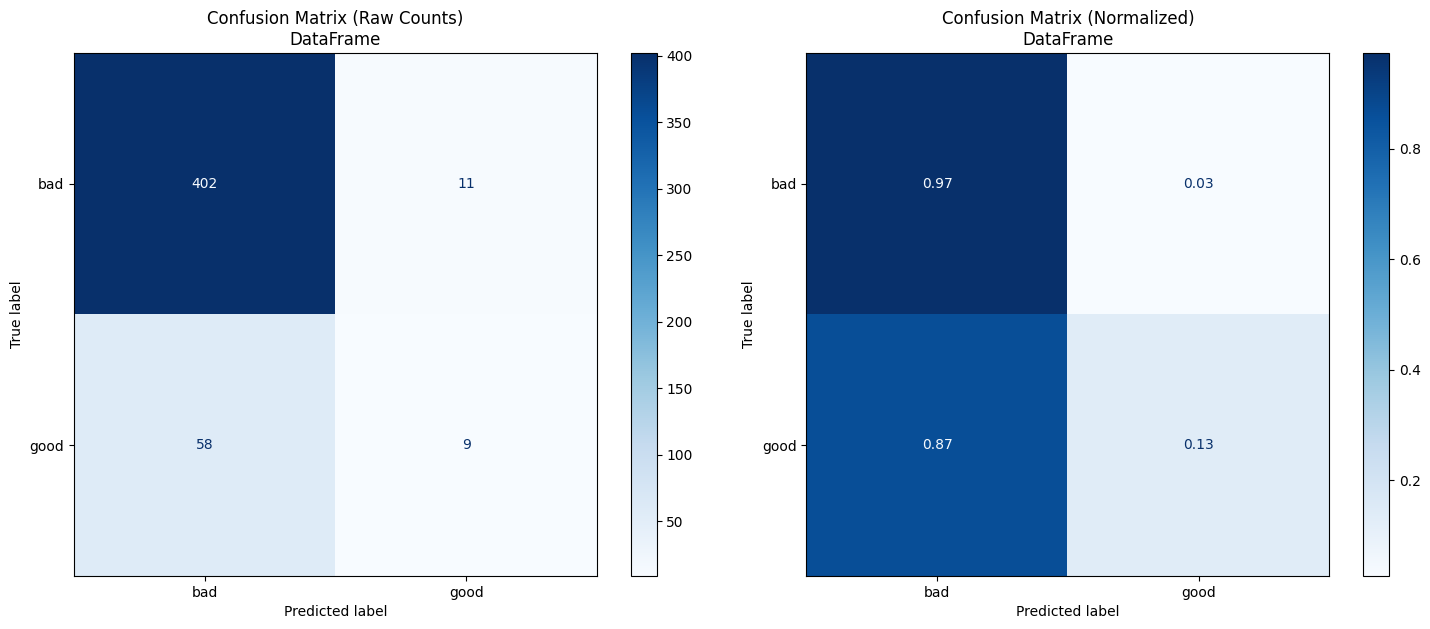

Processing White Wine...
Best Folds: 10 | Best Score: 0.6208296807608329
Best Folds: 10 | Best Score: 0.6208296807608329
              precision    recall  f1-score   support

         bad       0.83      0.96      0.89      1141
        good       0.68      0.29      0.41       329

    accuracy                           0.81      1470
   macro avg       0.75      0.63      0.65      1470
weighted avg       0.79      0.81      0.78      1470

              precision    recall  f1-score   support

         bad       0.83      0.96      0.89      1141
        good       0.68      0.29      0.41       329

    accuracy                           0.81      1470
   macro avg       0.75      0.63      0.65      1470
weighted avg       0.79      0.81      0.78      1470



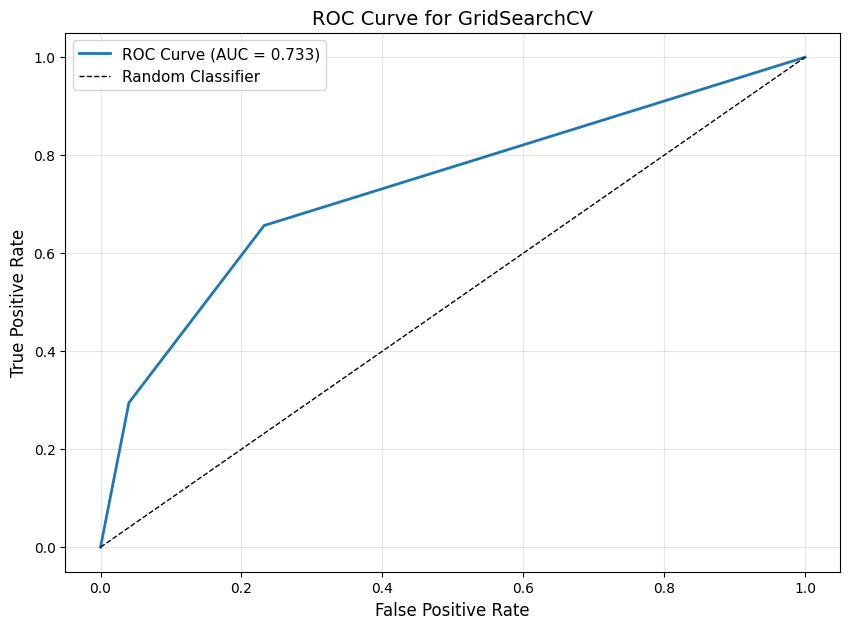

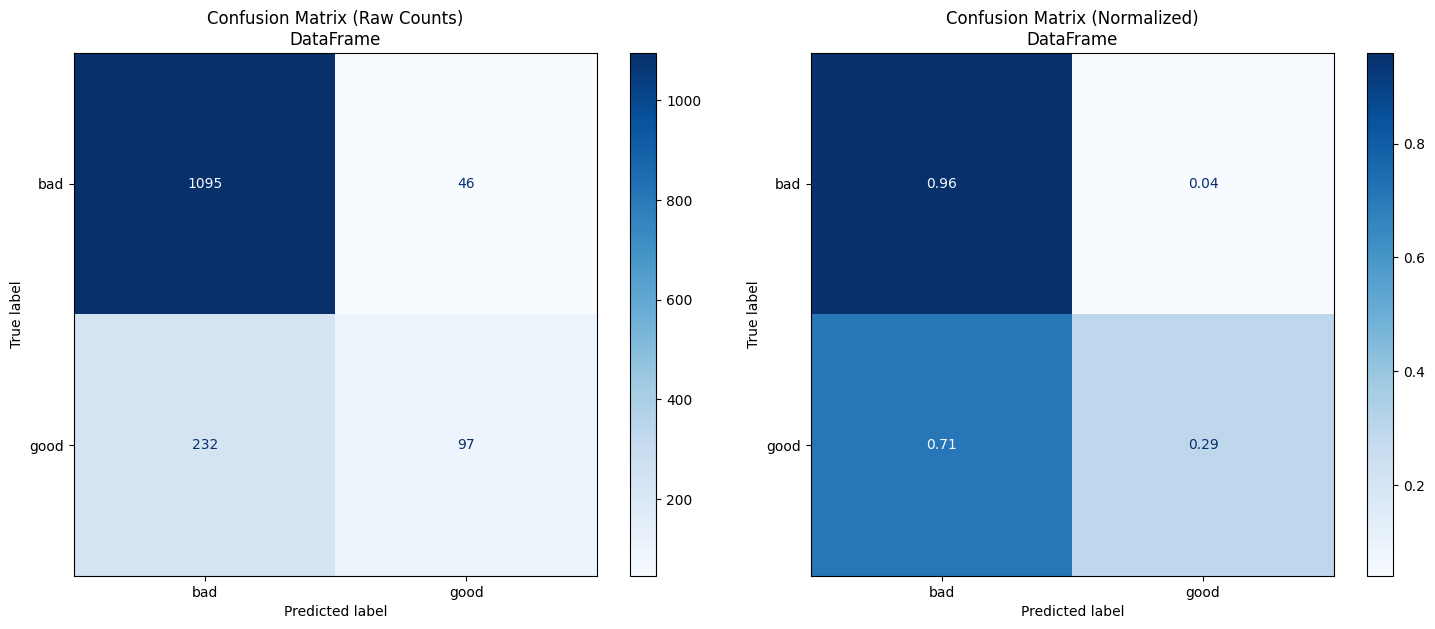

Processing Combined Wine...
Best Folds: 9 | Best Score: 0.6357073188571196
Best Folds: 9 | Best Score: 0.6357073188571196
              precision    recall  f1-score   support

         bad       0.86      0.95      0.90      1585
        good       0.57      0.31      0.40       365

    accuracy                           0.83      1950
   macro avg       0.71      0.63      0.65      1950
weighted avg       0.80      0.83      0.81      1950

              precision    recall  f1-score   support

         bad       0.86      0.95      0.90      1585
        good       0.57      0.31      0.40       365

    accuracy                           0.83      1950
   macro avg       0.71      0.63      0.65      1950
weighted avg       0.80      0.83      0.81      1950



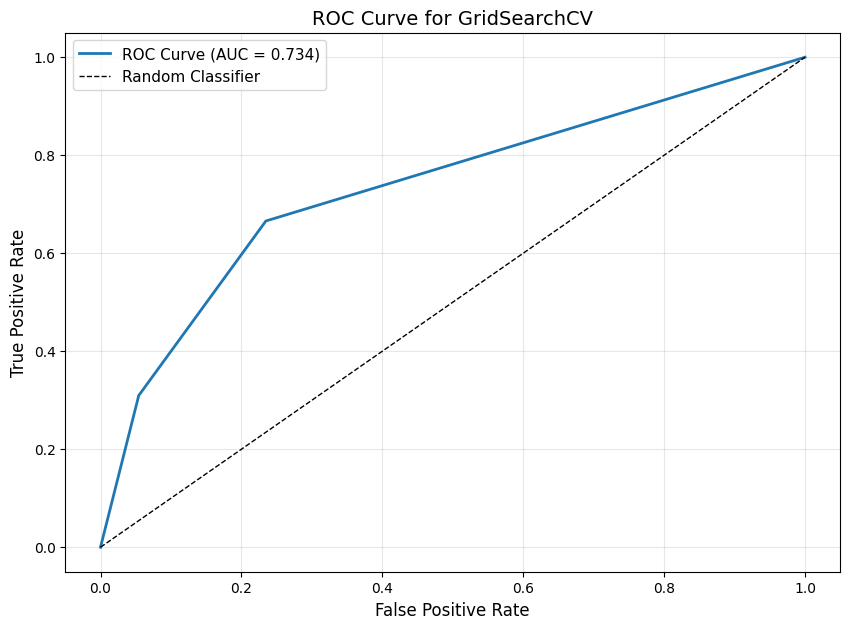

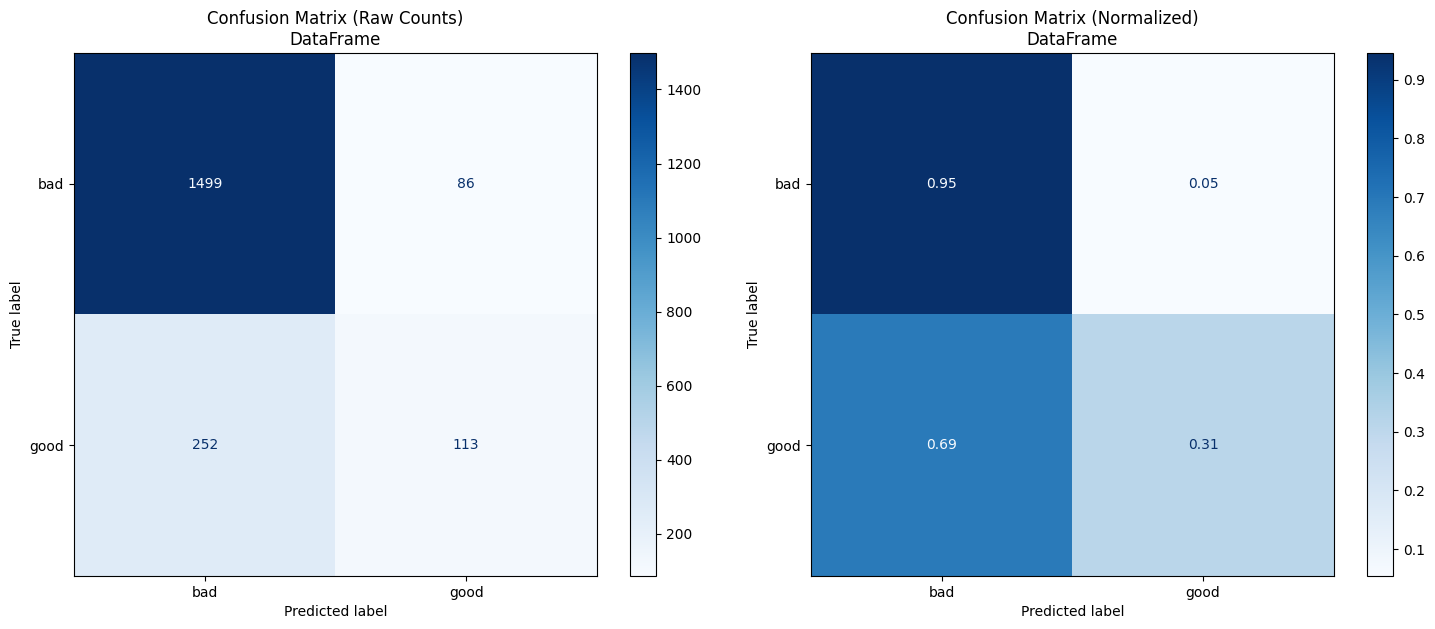

In [10]:
for i, df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]}...")
    print("=" * 40)

    X = df.drop(columns=['quality', 'quality_category', 'color'])
    y = df['quality_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # find optimized K value
    cv_best = optimized_folds(KNeighborsClassifier(), X_train, y_train)
    param_grid = {'n_neighbors': range(1, 20)}
    knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_best)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))

    y_scores = get_probability_scores(knn, X_test)
    # pr_curve(y_test, y_scores, knn)
    roc_curve_plot(y_test, y_scores, knn)

    confusion_matrix_plot(y_test, y_pred, knn, df)

Processing Red Wine...
Best Folds: 10 | Best Score: 0.8781596559070538
Best Folds: 10 | Best Score: 0.8781596559070538
              precision    recall  f1-score   support

         bad       0.94      0.87      0.90       413
        good       0.44      0.63      0.52        67

    accuracy                           0.84       480
   macro avg       0.69      0.75      0.71       480
weighted avg       0.87      0.84      0.85       480

              precision    recall  f1-score   support

         bad       0.94      0.87      0.90       413
        good       0.44      0.63      0.52        67

    accuracy                           0.84       480
   macro avg       0.69      0.75      0.71       480
weighted avg       0.87      0.84      0.85       480



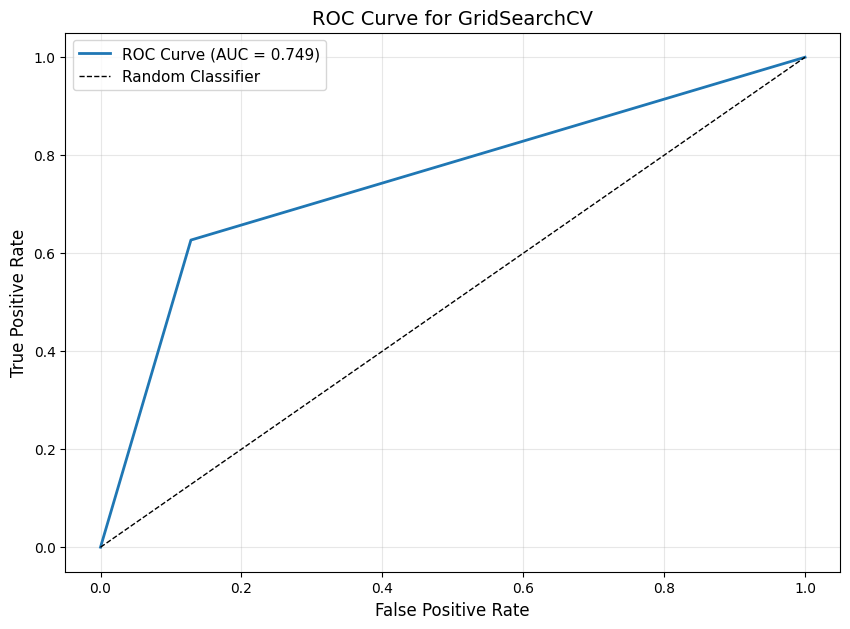

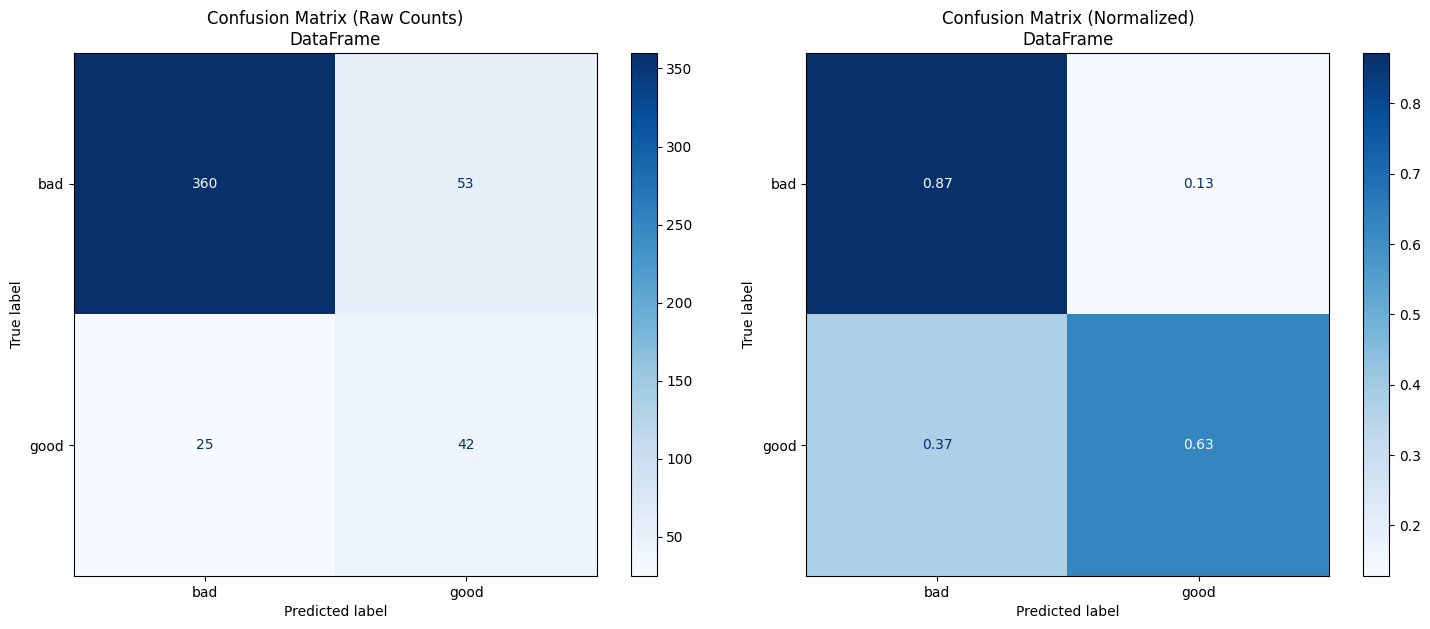

Processing White Wine...
Best Folds: 10 | Best Score: 0.8184398552015922
Best Folds: 10 | Best Score: 0.8184398552015922
              precision    recall  f1-score   support

         bad       0.88      0.84      0.86      1141
        good       0.51      0.60      0.55       329

    accuracy                           0.78      1470
   macro avg       0.70      0.72      0.71      1470
weighted avg       0.80      0.78      0.79      1470

              precision    recall  f1-score   support

         bad       0.88      0.84      0.86      1141
        good       0.51      0.60      0.55       329

    accuracy                           0.78      1470
   macro avg       0.70      0.72      0.71      1470
weighted avg       0.80      0.78      0.79      1470



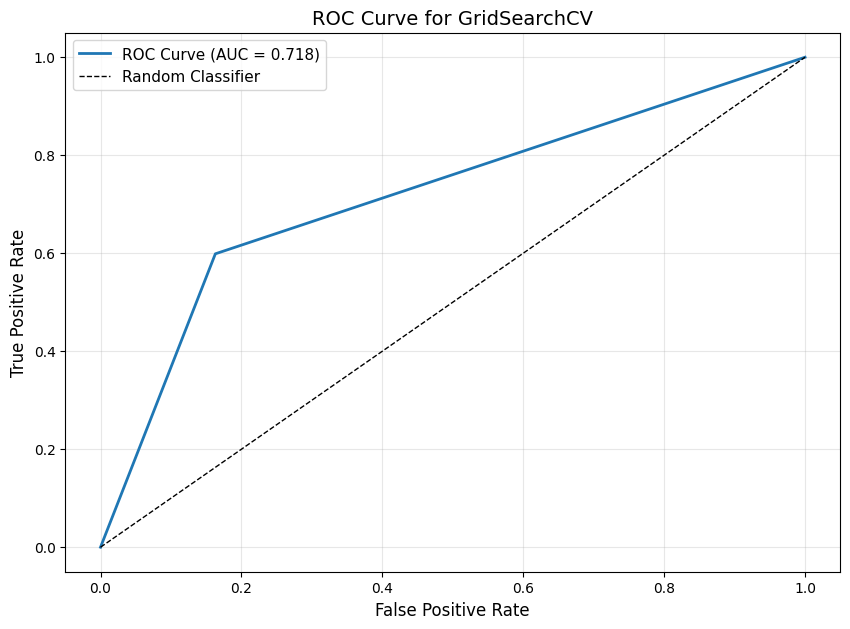

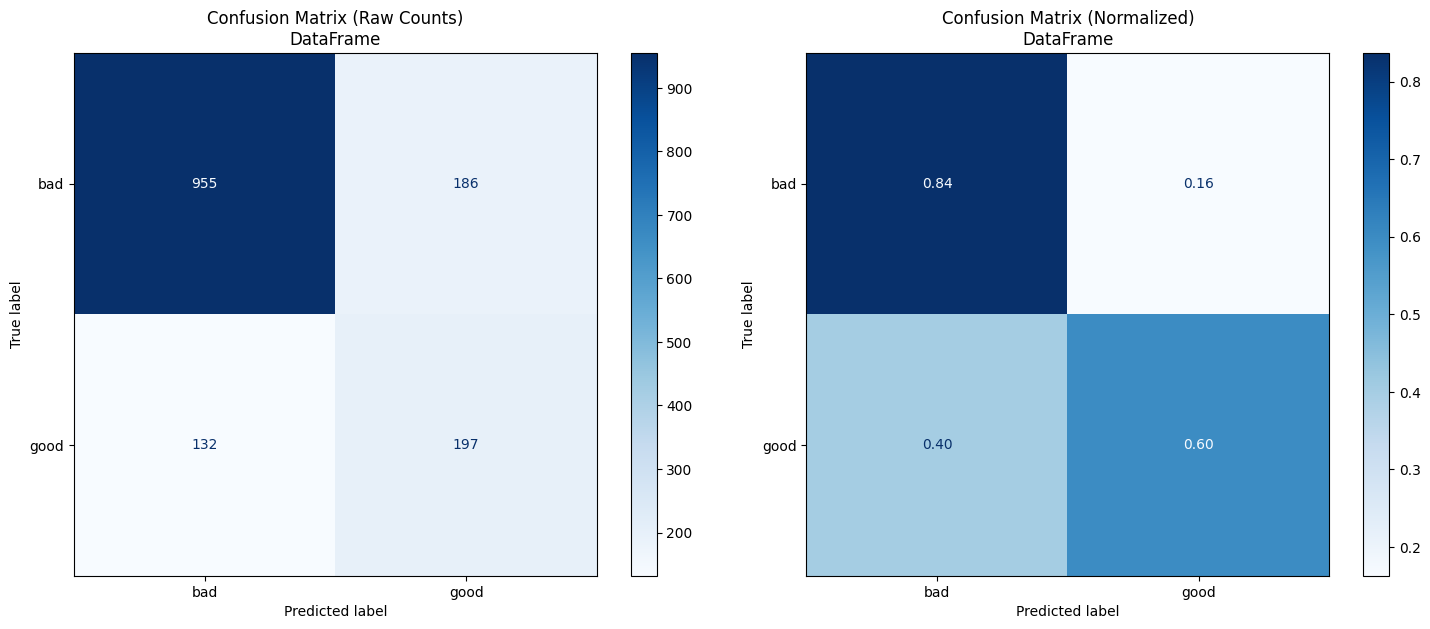

Processing Combined Wine...
Best Folds: 9 | Best Score: 0.8314655290122084
Best Folds: 9 | Best Score: 0.8314655290122084
              precision    recall  f1-score   support

         bad       0.91      0.82      0.86      1585
        good       0.46      0.64      0.53       365

    accuracy                           0.79      1950
   macro avg       0.68      0.73      0.70      1950
weighted avg       0.82      0.79      0.80      1950

              precision    recall  f1-score   support

         bad       0.91      0.82      0.86      1585
        good       0.46      0.64      0.53       365

    accuracy                           0.79      1950
   macro avg       0.68      0.73      0.70      1950
weighted avg       0.82      0.79      0.80      1950



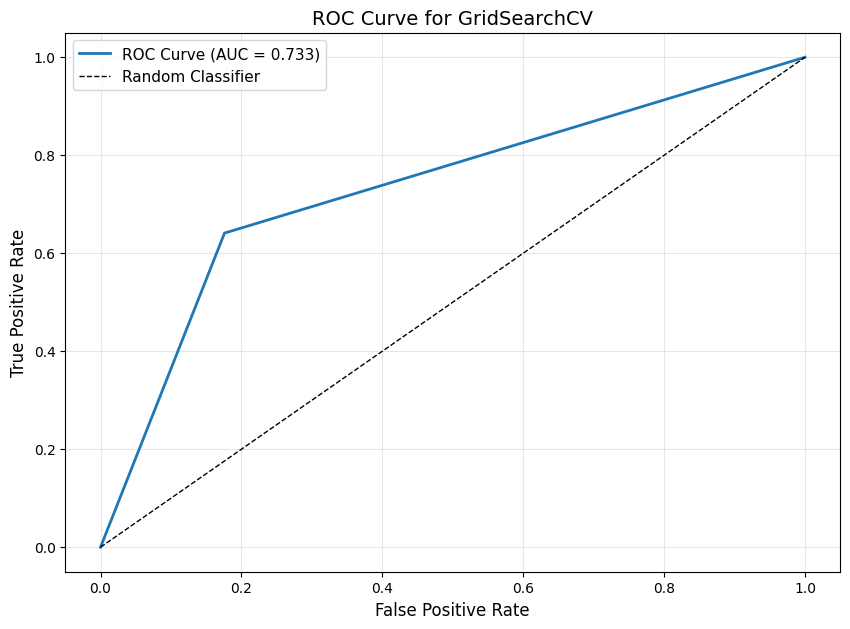

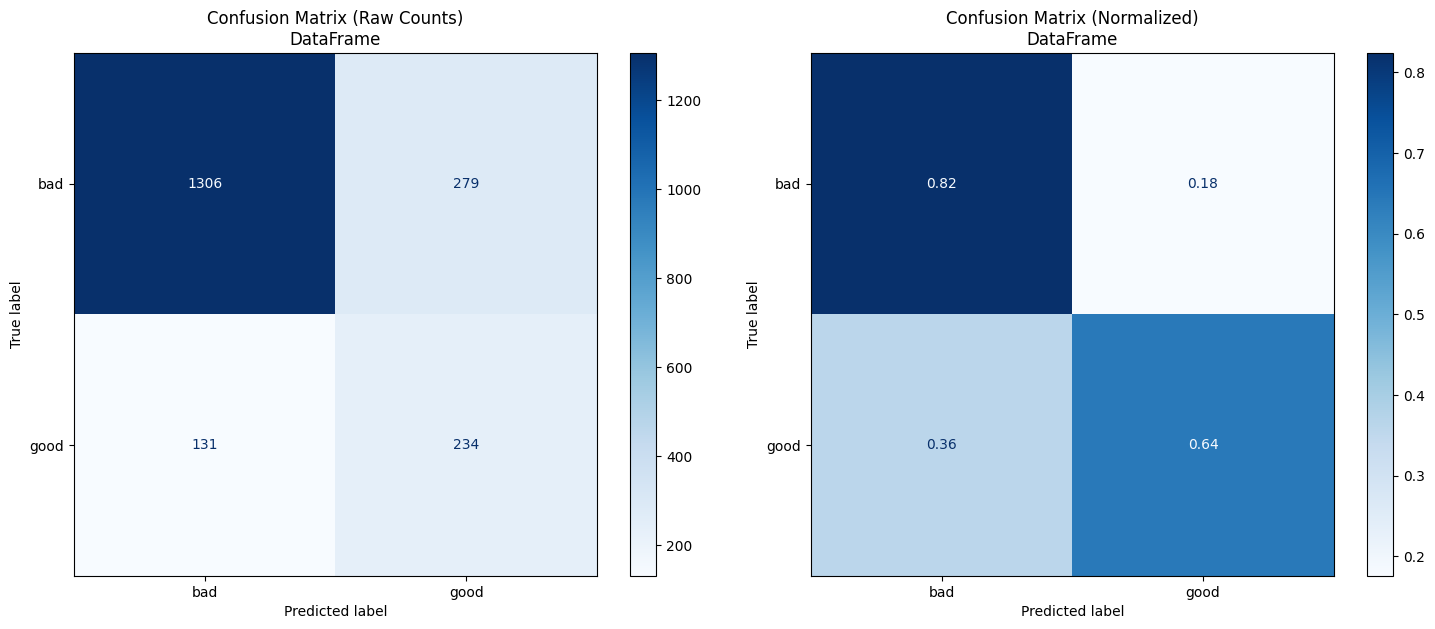

In [11]:
for i, df in enumerate(df_array):
    print("=" * 40)
    print(f"Processing {df_names[i]}...")
    print("=" * 40)

    X = df.drop(columns=['quality', 'quality_category', 'color'])
    y = df['quality_category']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # find optimized K value
    cv_best = optimized_folds(KNeighborsClassifier(), X_train, y_train)
    param_grid = {'n_neighbors': range(1, 20)}
    knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=cv_best)
    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))

    y_scores = get_probability_scores(knn, X_test)
    # pr_curve(y_test, y_scores, knn)
    roc_curve_plot(y_test, y_scores, knn)

    confusion_matrix_plot(y_test, y_pred, knn, df)